# Analyzing AudioSeal’s Capabilities: Localization of Synthetic Speech Segments
---
Evaluate the accuracy and precision of the AudioSeal system in localizing synthetic speech segments within an audio stream.

In [1]:
import os
import torch
import torchaudio
import numpy as np
import typing as tp
from typing import List, Tuple
from audioseal import AudioSeal
import random
from tqdm import tqdm

## Preparing the Model for generating and detecting synthetic speech segments

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

secret_message = torch.randint(0, 2, (1, 16), dtype=torch.int32)
secret_message = secret_message.to(device)
print(f"Secret message: {secret_message}")


model = AudioSeal.load_generator("audioseal_wm_16bits")
detector = AudioSeal.load_detector("audioseal_detector_16bits")


model = model.to(device)
detector = detector.to(device)

def generate_watermark_audio(
    tensor: torch.Tensor,
    sample_rate: int
) -> tp.Optional[torch.Tensor]:
    try:
        global model, device, secret_message
        audios = tensor.unsqueeze(0).to(device)
        watermarked_audio = model(audios, sample_rate=sample_rate, message=secret_message.to(device), alpha=1)
        del audios
        return watermarked_audio

    
    except Exception as e:
        print(f"Error while watermarking audio: {e}")
        return None

# Function to get the confidence score that an audio tensor was watermarked by Audioseal
# provided by the Audioseal team
def detect_watermark_audio(
    tensor: torch.Tensor,
    sample_rate: int,
    message_threshold: float = 0.50
) -> tp.Optional[float]:
    try:
        global detector, device
        # In our analysis we are not concerned with the hidden/embedded message as of now
        result, _ = detector.detect_watermark(tensor, sample_rate=sample_rate, message_threshold=message_threshold)
        return float(result)
    except Exception as e:
        print(f"Error while detecting watermark: {e}")
        return None

Using device: cuda
Secret message: tensor([[1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]], device='cuda:0',
       dtype=torch.int32)


In [3]:
CREMA_D_PATH = '../../crema-d'
SAMPLE_SIZE = 100
OUTPUT_DIR = './localized_dataset'

## Preparing the dataset

In [4]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_audio_files(directory: str) -> List[Tuple[str, int]]:
    audio_files = []
    for filename in random.sample(os.listdir(directory), SAMPLE_SIZE):
        if filename.endswith('.wav'):
            filepath = os.path.join(directory, filename)
            sample_rate = torchaudio.info(filepath).sample_rate
            audio_files.append((filepath, sample_rate))
    return audio_files

def create_mixed_audio(original: torch.Tensor, watermarked: torch.Tensor, ratio: float) -> torch.Tensor:
    assert 0.0 <= ratio <= 1.0, "Ratio must be between 0 and 1"
    
    split_factor = 100
    # divide original and watermarked audio into split_factor equal parts
    original_parts = torch.chunk(original, split_factor, dim=1)
    watermarked_parts = torch.chunk(watermarked.view(1,-1), split_factor, dim=1)

    # mix the audio parts based on the ratio
    mixed_parts = []
    watermark_sequence = []
    for i in range(split_factor):
        take_watermarked = random.random() < ratio
        if take_watermarked:
            mixed_parts.append(watermarked_parts[i])
            watermark_sequence.extend([1] * watermarked_parts[i].size(1))
        else:
            mixed_parts.append(original_parts[i])
            watermark_sequence.extend([0] * original_parts[i].size(1))
    
    mixed_audio = torch.cat(mixed_parts, dim=1)
    return mixed_audio, watermark_sequence

def process_audio_file(filepath: str, sample_rate: int, ratios: List[float], output_dir: str) -> None:
    waveform, _ = torchaudio.load(filepath)
    waveform = waveform.to(device)

    watermarked_waveform = generate_watermark_audio(waveform, sample_rate)
    if watermarked_waveform is None:
        return

    watermarked_waveform = watermarked_waveform.to(device)

    for ratio in ratios:
        mixed_audio, watermark_sequence = create_mixed_audio(waveform, watermarked_waveform, ratio)

        # Convert mixed audio to int16 before saving
        mixed_audio_int16 = (mixed_audio * 32767).clamp(-32768, 32767).short()

        # Save the mixed audio and watermark sequence to files
        output_filepath = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(filepath))[0]}_ratio_{ratio}.wav")
        torchaudio.save(output_filepath, mixed_audio_int16.cpu().view(1,-1), sample_rate)

        watermark_filepath = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(filepath))[0]}_ratio_{ratio}_watermark.npy")
        np.save(watermark_filepath, watermark_sequence)

    # Release GPU memory
    del waveform
    del watermarked_waveform
    torch.cuda.empty_cache()

def generate_dataset(audio_files: List[Tuple[str, int]], output_dir: str) -> None:
    ratios = [0.0, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0]

    for filepath, sample_rate in tqdm(audio_files):
        process_audio_file(filepath, sample_rate, ratios, output_dir)

In [7]:

audio_files = load_audio_files(CREMA_D_PATH)
generate_dataset(audio_files, OUTPUT_DIR)

100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


## Testing the localization capabilities of the AudioSeal system

In [16]:
# create a dictionary to store the file paths and the corresponding watermark sequences for each ratio
watermark_dict = {}
for filename in os.listdir(OUTPUT_DIR):
    if filename.endswith('.npy'):
        watermark_sequence = np.load(os.path.join(OUTPUT_DIR, filename))
        audio_filename = filename.split('_ratio')[0]
        if audio_filename not in watermark_dict:
            watermark_dict[audio_filename] = {}
        ratio = float(filename.split('_ratio')[1].split('_')[1])
        watermark_dict[audio_filename][ratio] = {}

In [72]:
for file in tqdm(watermark_dict):
    for ratio in watermark_dict[file]:
        watermark_filepath = os.path.join(OUTPUT_DIR, f"{file}_ratio_{ratio}_watermark.npy")
        watermark_sequence = np.load(watermark_filepath)
        
        # load the corresponding audio file
        audio_filepath = os.path.join(OUTPUT_DIR, f"{file}_ratio_{ratio}.wav")
        audio, sr = torchaudio.load(audio_filepath)
        pred_prob, message_prob = detector(audio.unsqueeze(0).to(device), sample_rate=sr)

        
        pred_prob_binary = np.where(pred_prob.cpu() > 0.5, 1, 0)


        precision = np.sum(np.logical_and(watermark_sequence == 1, pred_prob_binary == 1)) / np.sum(pred_prob_binary)
        recall = np.sum(np.logical_and(watermark_sequence == 1, pred_prob_binary == 1)) / np.sum(watermark_sequence)
        f1_score = 2 * (precision * recall) / (precision + recall)

        watermark_dict[file][ratio] = {
            'watermark_sequence': watermark_sequence,
            'pred_prob_binary': pred_prob_binary,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        }

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\drwho\AppData\Local\Temp\ipykernel_34600\119487318.py:16: RuntimeWarning: invalid value encountered in scalar divide
  recall = np.sum(np.logical_and(watermark_sequence == 1, pred_prob_binary == 1)) / np.sum(watermark_sequence)
100%|██████████| 100/100 [00:13<00:00,  7.44it/s]


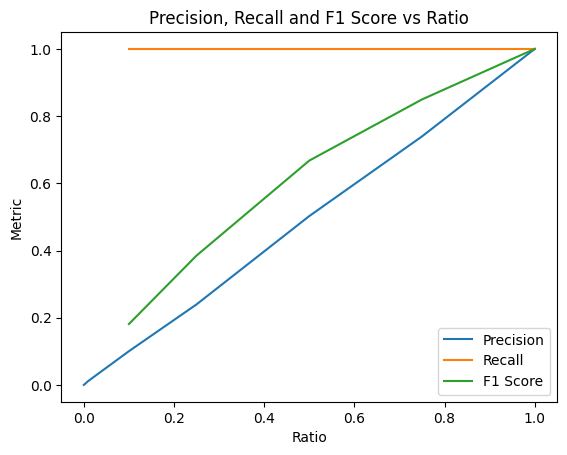

In [74]:
# plot the aggregated precision, recall and f1 score

import matplotlib.pyplot as plt

ratios = [0.0, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0]
precision = []
recall = []
f1_score = []

for ratio in ratios:
    precision_ratio = []
    recall_ratio = []
    f1_score_ratio = []
    for file in watermark_dict:
        precision_ratio.append(watermark_dict[file][ratio]['precision'])
        recall_ratio.append(watermark_dict[file][ratio]['recall'])
        f1_score_ratio.append(watermark_dict[file][ratio]['f1_score'])
    precision.append(np.mean(precision_ratio))
    recall.append(np.mean(recall_ratio))
    f1_score.append(np.mean(f1_score_ratio))

plt.plot(ratios, precision, label='Precision')
plt.plot(ratios, recall, label='Recall')
plt.plot(ratios, f1_score, label='F1 Score')
plt.xlabel('Ratio')
plt.ylabel('Metric')
plt.title('Precision, Recall and F1 Score vs Ratio')
plt.legend()
plt.show()